In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

In [20]:
import numpy as np
from IPython.display import display, HTML

import matplotlib
matplotlib.use("cairo")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

%matplotlib inline

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Helpers

In [3]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

In [ ]:
df_atp.to_csv("df_atp.csv")
df_wta.to_csv("df_wta.csv")

#### If the dataset is already available

In [3]:
df_atp = pd.read_csv("df_atp.csv", index_col=0, low_memory=False)
df_atp["Date"] = pd.to_datetime(df_atp["Date"])

df_atp.head(5)

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,UBW,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,63,Dosedel S.,2.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,5,Enqvist T.,2.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,7.0,6.0,NaN,NaN,NaN,40,Escude N.,2.0
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,65,Federer R.,2.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,7.0,5.0,6.0,NaN,NaN,NaN,81,Fromberg R.,2.0


## Your work

#### Helpers Functions

In [4]:
def mutual_hist(data1, data1_name, data1_color, data2, data2_name, data2_color, x_label, y_label, title):
    """
    Plot overlaid histograms of two distributions
    """
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins
    bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

### Q1. The three (3) ATP players with most wins

In [5]:
df_atp.groupby("Winner").size().sort_values(ascending=False).head(3)

# .groupby : Creates groups each holding rows with unique column value
# .size    : Returns size of each group
# .sort_values : Sorts the Panda Series (actually in descending order)
# .head        : Returns the N foremost elements

Winner
Federer R.     1108
Nadal R.        891
Djokovic N.     789
dtype: int64

### Q2. The number of sets won by Roger Federer

In [6]:
# We filter the ATP dataframe to get Federer's matches
# To do so, we need to make sure that our research is case-insensitive
# Also we could use regular expressions
df_federer = df_atp[df_atp["Winner"].str.contains('federer', case=False)]
sets_won = int(df_federer["Wsets"].sum())

display(HTML("<h4>The number of sets won in total by R. Federer is : {} sets".format(sets_won)))

### Q3. The number of sets won by Roger Federer in 2016 and 2017

In [7]:
# For 2016 only
sets_won_2016 = df_federer[df_federer["Date"].dt.year == 2016]["Wsets"].sum()
sets_won_2016 = int(sets_won_2016)

# For 2017 only
sets_won_2017 = df_federer[df_federer["Date"].dt.year == 2017]["Wsets"].sum()
sets_won_2017 = int(sets_won_2017)

# For both 2016 and 2017 (For the sake of using multiple filtering criterias)
sets_won_2016_2017 = df_federer[(df_federer["Date"].dt.year == 2016) | (df_federer["Date"].dt.year == 2017)]["Wsets"].sum()
sets_won_2016_2017 = int(sets_won_2016_2017)

display(HTML("<h4>The number of sets won in 2016 by R. Federer is : {} sets".format(sets_won_2016)))
display(HTML("<h4>The number of sets won in 2017 by R. Federer is : {} sets".format(sets_won_2017)))
display(HTML("<h4>The number of sets won in 2016 and 2017 by R. Federer is : {} sets".format(sets_won_2016_2017)))

### Q4. Percentage of winner victories prior to each match

###### The solution to this question is computationally extensive
- We try to solve this issue by either parallelizing the Pandas' `apply` method using a library (e.g. Dask).
- Or, we adopt C-compiled code using Cython

In [8]:
%load_ext Cython

In [9]:
%%cython
cpdef double prior_wins_percentage(date, str player, df, int min_games=5):
    """
    @arg
    """
    cpdef df_prior;
    cdef int prior_wins;
    cdef int prior_losses;
    
    df_prior = df[df["Date"] < date]
    prior_wins = df_prior[df_prior["Winner"] == player].shape[0]
    prior_losses = df_prior[df_prior["Loser"] == player].shape[0]
    
    # We set a minimum number of games to avoid extra-high win rates
    # (e.g. like at a professional career debut)
    if (prior_wins + prior_losses) < min_games:
        return 0
    return prior_wins / (prior_wins + prior_losses)

In [ ]:
df_atp["winner_prior_wins"] = df_atp.apply(
    lambda row: prior_wins_percentage(
        row["Date"],
        row["Winner"],
        df_atp
    ),
    axis=1
)

In [ ]:
df_atp["loser_prior_wins"] = df_atp.apply(
    lambda row: prior_wins_percentage(
        row["Date"],
        row["Loser"],
        df_atp
    ),
    axis=1
)

###### Save to a local CSV file

In [12]:
# df_atp.to_csv("atp_prior_wins.csv")

df_atp = pd.read_csv("atp_prior_wins.csv", index_col=0, low_memory=False)
df_atp["Date"] = pd.to_datetime(df_atp["Date"])

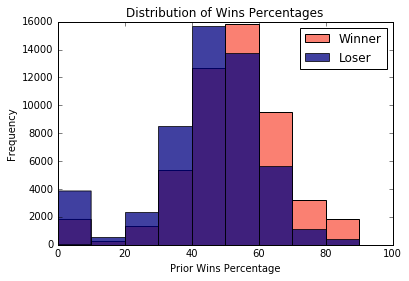

In [13]:
mutual_hist(data1 = df_atp["winner_prior_wins"].apply(lambda x: x * 100)
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_atp["loser_prior_wins"].apply(lambda x: x * 100)
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Prior Wins Percentage'
                   , y_label = 'Frequency'
                   , title = 'Distribution of Wins Percentages')

### Plotting the Carreer Progress of Top 3 ATP Players

In [ ]:
x_nadal = df_atp[df_atp["Winner"].str.contains("nadal", case=False)]["Date"].values
y_nadal = df_atp[df_atp["Winner"].str.contains("nadal", case=False)]["winner_prior_wins"].values

fig, ax = plt.subplots()
ax.plot(x_nadal, y_nadal);

fig.show()

In [62]:
df_top3 = df_atp[
    (df_atp["Winner"].str.contains("federer", case=False)) | \
    (df_atp["Winner"].str.contains("nadal", case=False)) | \
    (df_atp["Winner"].str.contains("djokovic", case=False))
][["Winner", "Date", "winner_prior_wins"]]

df_top3 = df_top3.drop(df_top3[df_top3["winner_prior_wins"] == 0.0].index)

In [63]:
x_date = []
y_federer = []
y_nadal = []
y_djokovic = []

for date, group in df_top3.groupby(["Date"]):
    x_date.append(date)
    try:
        y_federer.append(group[group["Winner"].str.contains("federer", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_federer.append(y_federer[-1] if len(y_federer) else 0.0)
    try:
        y_nadal.append(group[group["Winner"].str.contains("nadal", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_nadal.append(y_nadal[-1] if len(y_nadal) else 0.0)
    try:
        y_djokovic.append(group[group["Winner"].str.contains("djokovic", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_djokovic.append(y_djokovic[-1] if len(y_djokovic) else 0.0)

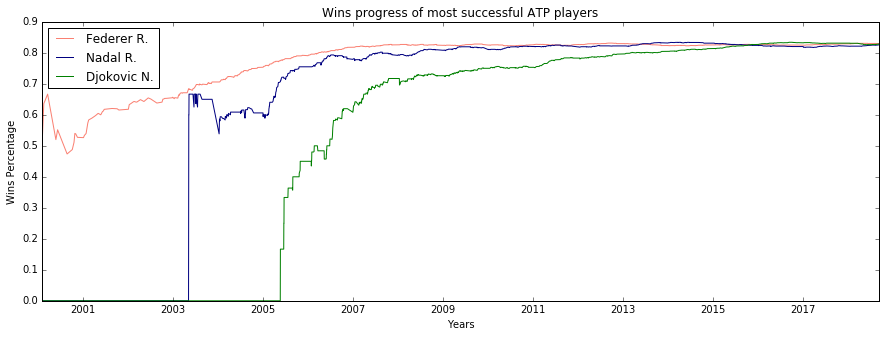

In [68]:
plt.figure(figsize=(15, 5))

plt.plot(x_date, y_federer, color='salmon', label="Federer R.")
plt.plot(x_date, y_nadal, color='navy', label="Nadal R.")
plt.plot(x_date, y_djokovic, color='green', label="Djokovic N.")
plt.title("Wins progress of most successful ATP players")
plt.xlabel("Years")
plt.ylabel("Wins Percentage")
plt.legend(loc='best');

In [ ]:
df_atp = pd.read_csv("atp_prior_wins.csv", index_col=0)
df_atp["Date"] = pd.to_datetime(df_atp["Date"])